<a href="https://colab.research.google.com/github/b2204yo/supervisedPetClass/blob/develop/supervisedPetClass.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Google Driveをマウント

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# 新しいセクション

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist

In [24]:
from __future__ import print_function
import keras
from keras.applications import VGG16
from keras.models import Sequential, load_model, model_from_json
from keras import models, optimizers, layers
from keras.optimizers import SGD
from keras.layers import Dense, Dropout, Activation, Flatten
from sklearn.model_selection import train_test_split
from PIL import Image
from keras.preprocessing import image as images

from keras import backend as K
import os
import numpy as np
import glob
import pandas as pd
import cv2


GradCAM の関数

In [25]:
def Grad_Cam(input_model, pic_array, layer_name):

    # 前処理
    pic = np.expand_dims(pic_array, axis=0)
    pic = pic.astype('float32')
    preprocessed_input = pic / 255.0

    # 予測クラスの算出
    predictions = input_model.predict(preprocessed_input)
    class_idx = np.argmax(predictions[0])
    class_output = input_model.output[:, class_idx]

    #  勾配を取得
    conv_output = input_model.get_layer(layer_name).output   # layer_nameのレイヤーのアウトプット
    grads = K.gradients(class_output, conv_output)[0]  # gradients(loss, variables) で、variablesのlossに関しての勾配を返す
    gradient_function = K.function([input_model.input], [conv_output, grads])  # input_model.inputを入力すると、conv_outputとgradsを出力する関数

    output, grads_val = gradient_function([preprocessed_input])
    output, grads_val = output[0], grads_val[0]

    # 重みを平均化して、レイヤーのアウトプットに乗じる
    weights = np.mean(grads_val, axis=(0, 1))
    cam = np.dot(output, weights)

    # 画像化してヒートマップにして合成
    cam = cv2.resize(cam, (224, 224), cv2.INTER_LINEAR)
    cam = np.maximum(cam, 0)
    cam = cam / cam.max()

    jetcam = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)  # モノクロ画像に疑似的に色をつける
    jetcam = cv2.cvtColor(jetcam, cv2.COLOR_BGR2RGB)  # 色をRGBに変換
    jetcam = (np.float32(jetcam) + pic / 2)   # もとの画像に合成
    return jetcam

Downloading the data

In [ ]:
from google.colab import files
files.upload()

!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle competitions download -c dogs-vs-cats



Saving kaggle.json to kaggle.json
100% 812M/812M [00:37<00:00, 23.2MB/s]
100% 812M/812M [00:37<00:00, 22.9MB/s]
cp: cannot create regular file './drive/dogs-vs-cats.zip': Operation not supported


In [ ]:


!unzip -qq dogs-vs-cats.zip

# !unzip -qq train.zip

replace sampleSubmission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
 !unzip -qq train.zip

Copying images to training, validation, and test directories

In [31]:
import os, shutil, pathlib

original_dir = pathlib.Path("supervisedLearningPET/cats_vs_dogs_small/train")
new_base_dir = pathlib.Path("supervisedLearningPET/cats_vs_dogs_small")

# def make_subset(subset_name, start_index, end_index):
#     for category in ("cat", "dog"):
#         dir = new_base_dir / subset_name / category
#         os.makedirs(dir)
#         fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
#         for fname in fnames:
#             shutil.copyfile(src=original_dir / fname,
#                             dst=dir / fname)

# make_subset("train", start_index=0, end_index=1000)
# make_subset("validation", start_index=1000, end_index=1500)
# make_subset("test", start_index=1500, end_index=2500)

Select learning model

Set picuter setting

In [27]:
learning_model_name = "VGG16"
# VGG16 : 180, Efficient Net 224

if learning_model_name == "VGG16":
  num_picel_units = 180
  num_epoch = 30
  conv_base  = keras.applications.vgg16.VGG16(
     weights="imagenet",
     include_top=False)

elif learning_model_name == "EfficientNetV2":
  num_picel_units = 224
  num_epoch = 350
  conv_base = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(weights="imagenet")

Data preprocessing

In [32]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(num_picel_units, num_picel_units),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(num_picel_units, num_picel_units),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(num_picel_units, num_picel_units),
    batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


In [33]:
import numpy as np
import tensorflow as tf
random_numbers = np.random.normal(size=(1000, 16))
dataset = tf.data.Dataset.from_tensor_slices(random_numbers)

In [34]:
for i, element in enumerate(dataset):
    print(element.shape)
    if i >= 2:
        break

(16,)
(16,)
(16,)


In [35]:
batched_dataset = dataset.batch(32)
for i, element in enumerate(batched_dataset):
    print(element.shape)
    if i >= 2:
        break

(32, 16)
(32, 16)
(32, 16)


In [36]:
reshaped_dataset = dataset.map(lambda x: tf.reshape(x, (4, 4)))
for i, element in enumerate(reshaped_dataset):
    print(element.shape)
    if i >= 2:
        break

(4, 4)
(4, 4)
(4, 4)


Displaying the shapes of the data and labels yielded by the Dataset

In [37]:
for data_batch, labels_batch in train_dataset:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    break

data batch shape: (32, 180, 180, 3)
labels batch shape: (32,)


Using image_dataset_from_directory to read images

In [38]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(num_picel_units, num_picel_units),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(num_picel_units, num_picel_units),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(num_picel_units, num_picel_units),
    batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


Instantiating the VGG16,ResNet, Mobilenet, Efficient Net convolutional base

In [39]:
# VGG16
# if learning_model_name == "VGG16":
#   conv_base  = keras.applications.vgg16.VGG16(
#      weights="imagenet",
#      include_top=False)

# # Efficient
# elif learning_model_name == "EfficientNetV2":
#   conv_base = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(weights="imagenet")
conv_base.summary()
conv_base.trainable = False

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

Printing the list of trainable weights before and after freezing

In [40]:
conv_base.trainable = True
print("This is the number of trainable weights "
      "before freezing the conv base:", len(conv_base.trainable_weights))

This is the number of trainable weights before freezing the conv base: 26


In [41]:
conv_base.trainable = False
print("This is the number of trainable weights "
      "after freezing the conv base:", len(conv_base.trainable_weights))

This is the number of trainable weights after freezing the conv base: 0


Adding a data augmentation stage and a classifier to the convolutional base

In [42]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

inputs = keras.Input(shape=(num_picel_units, num_picel_units, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

Evaluating the model on the test set

In [ ]:
conv_base.summary()

Freezing all layers until the fourth from the last

In [44]:
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

Fine-tuning the model

In [45]:
model.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="fine_tuning.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=num_epoch,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
63/63 [==============================] - 14s 189ms/step - loss: 3.2286 - accuracy: 0.7800 - val_loss: 0.5253 - val_accuracy: 0.9360
Epoch 2/30
63/63 [==============================] - 12s 186ms/step - loss: 1.0530 - accuracy: 0.8805 - val_loss: 0.2637 - val_accuracy: 0.9560
Epoch 3/30
63/63 [==============================] - 11s 171ms/step - loss: 0.5802 - accuracy: 0.9150 - val_loss: 0.2136 - val_accuracy: 0.9630
Epoch 4/30
63/63 [==============================] - 11s 166ms/step - loss: 0.4112 - accuracy: 0.9325 - val_loss: 0.1535 - val_accuracy: 0.9730
Epoch 5/30
63/63 [==============================] - 11s 170ms/step - loss: 0.3425 - accuracy: 0.9365 - val_loss: 0.1418 - val_accuracy: 0.9690
Epoch 6/30
63/63 [==============================] - 13s 198ms/step - loss: 0.2527 - accuracy: 0.9480 - val_loss: 0.1315 - val_accuracy: 0.9690
Epoch 7/30
63/63 [==============================] - 12s 194ms/step - loss: 0.1618 - accuracy: 0.9535 - val_loss: 0.1336 - val_accuracy: 0.9700

In [46]:
model = keras.models.load_model("fine_tuning.keras")
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 7s 91ms/step - loss: 0.1342 - accuracy: 0.9740
Test accuracy: 0.974


Plot result graph

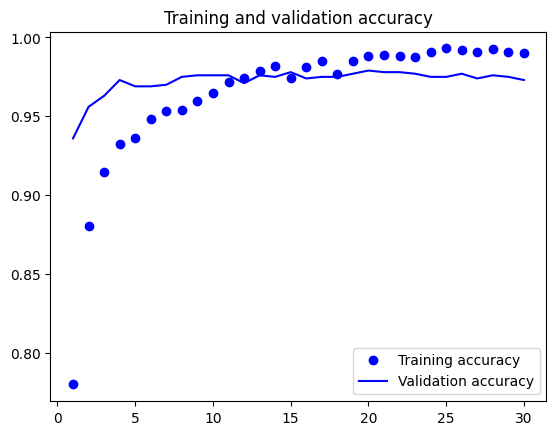

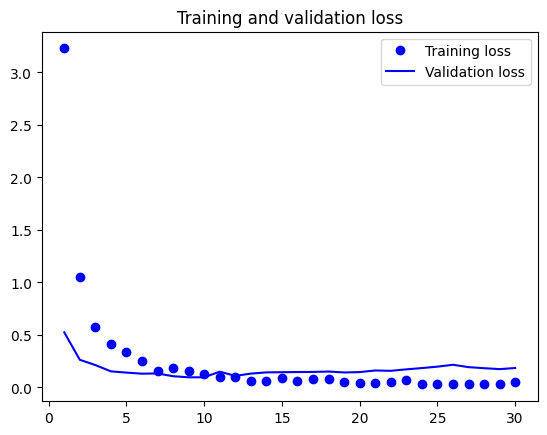

In [47]:
import matplotlib.pyplot as plt
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

Heatmap を作る関数

In [52]:
def make_heatmap(last_conv_layer_name, model, target_image):
    with tf.GradientTape() as tape:
        last_conv_layer = model.get_layer(last_conv_layer_name)  # 最後の畳込み層を取り出す
        iterate = tf.keras.models.Model([model.inputs], [model.output, last_conv_layer.output])
        model_out, last_conv_layer = iterate(target_image)
        class_out = model_out[:, np.argmax(model_out[0])]
        grads = tape.gradient(class_out, last_conv_layer)
        pooled_grads = K.mean(grads, axis=(0, 1, 2))

    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, last_conv_layer), axis=-1)

    heatmap_shape = (grads.shape[1], grads.shape[2])

    # ヒートマップの値を正規化
    heatmap_Emphasis = np.maximum(heatmap, 0)
    heatmap_Emphasis /= np.max(heatmap_Emphasis)
    heatmap_Emphasis = heatmap_Emphasis.reshape(heatmap_shape)
    plt.matshow(heatmap_Emphasis)
    plt.show()

    return heatmap_Emphasis



ImportError: ignored